# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Загрузим библиотеки

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor

import lightgbm as lgb

In [4]:
RANDOM_SEED = 666

### Загрузим данные

In [6]:
data =  pd.read_csv('datasets/autos.csv')

### Изучим исходные данные

Для этого воспользуемся функцией, чтобы наглядно посмотреть на возможные пустые значения в атрибутах, а также дубликаты и уникальные значения

In [8]:
def check_df(data):
    empty_values = data.isnull().sum()
    duplicate_values = data.duplicated().sum()
    distinct_values = data.nunique()
    explore_data = pd.DataFrame({'column': empty_values.index, 
                                 'empty': empty_values.values, 
                                 'duplicated': duplicate_values, 
                                 'distinct': distinct_values.values})
    
    return explore_data

In [9]:
explore_data = check_df(data)

In [10]:
display(explore_data)

,column,empty,duplicated,distinct
0,DateCrawled,0,4,271174
1,Price,0,4,3731
2,VehicleType,37490,4,8
3,RegistrationYear,0,4,151
4,Gearbox,19833,4,2
5,Power,0,4,712
6,Model,19705,4,250
7,Kilometer,0,4,13
8,RegistrationMonth,0,4,13
9,FuelType,32895,4,7


Помимо наличия пустот в 5 колонках <b>VehicleType, Gearbox, Model, FuelType, Repaired</b> мы так же можем заметить 4 дубликата во всех строках датафрейма, посмотрим внимательнее

In [11]:
explore_data2 = data[data.duplicated(keep=False)]

In [12]:
display(explore_data2)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
41529,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
88087,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
90964,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
187735,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


не уверен, что такое количество дубликатов может сильно повлиять на качество модели, но на всякий случай уберем лишние дубликаты, но оставим одно исходное значение

In [13]:
data = data.drop_duplicates(keep='first')

Теперь хочется посмотреть значения категориальных столбцов

In [14]:
def plot_column_diagram(data, column):
    value_counts = data[column].astype(str).value_counts(dropna=False)
    labels = value_counts.index
    counts = value_counts.values
    
    fig, ax = plt.subplots()
    
    colors = ['red' if label == 'nan' or label == '0' else 'black' for label in labels]
    ax.bar(labels, counts, color=colors)
    
    ax.set_xlabel(column)
    ax.set_ylabel('Количество')
    ax.set_title(f'Распределение категориальных значений столбца {column}')
    
    plt.xticks(rotation=90)
    plt.show()
    
    unique_values = data[column].unique()
    print(unique_values)

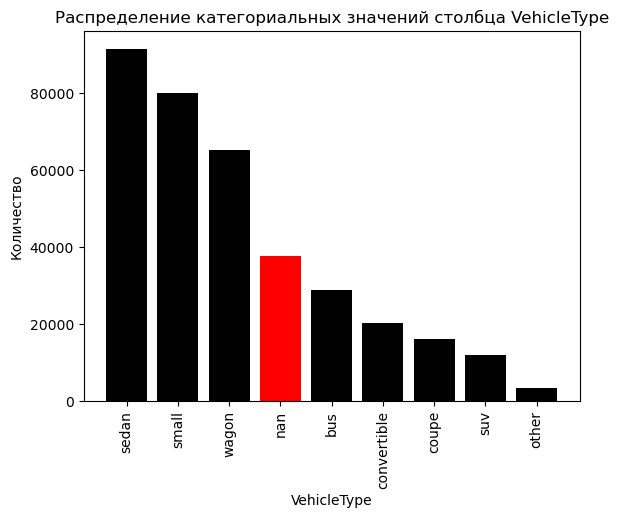

[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']


In [15]:
plot_column_diagram(data, 'VehicleType')

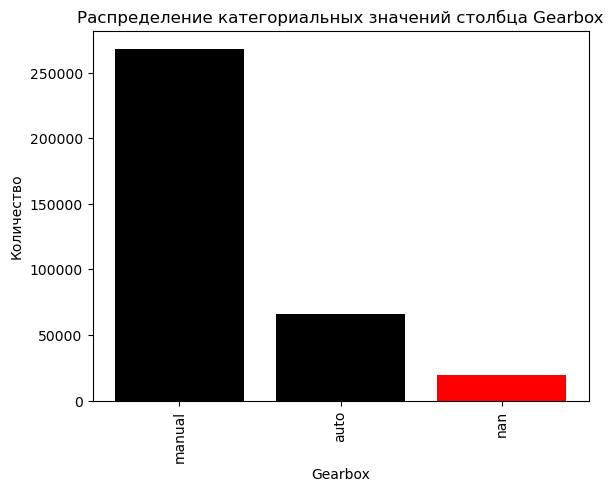

['manual' 'auto' nan]


In [16]:
plot_column_diagram(data, 'Gearbox')

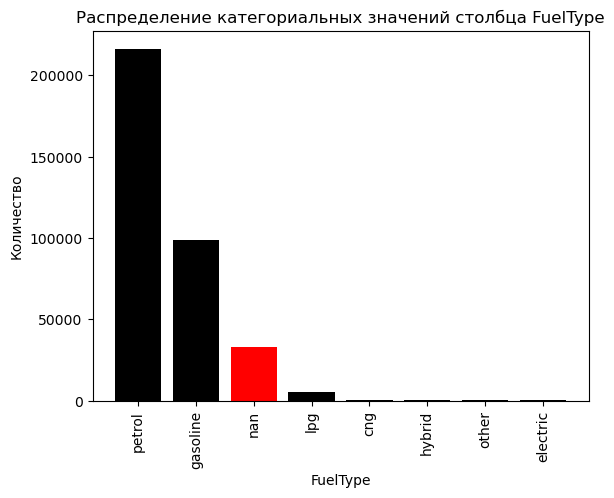

['petrol' 'gasoline' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']


In [17]:
plot_column_diagram(data, 'FuelType')

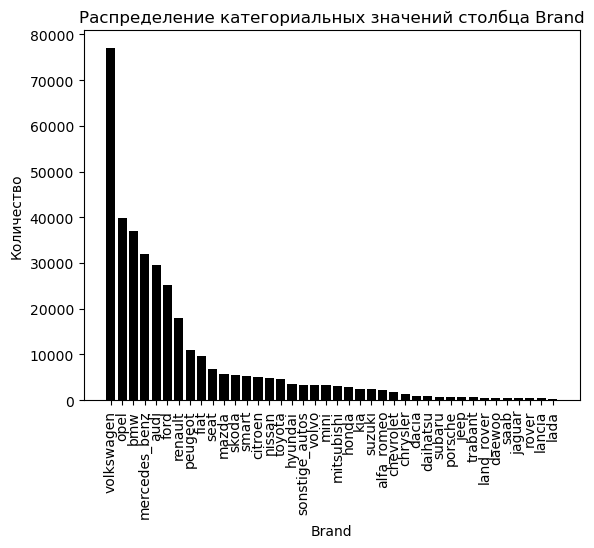

['volkswagen' 'audi' 'jeep' 'skoda' 'bmw' 'peugeot' 'ford' 'mazda'
 'nissan' 'renault' 'mercedes_benz' 'opel' 'seat' 'citroen' 'honda' 'fiat'
 'mini' 'smart' 'hyundai' 'sonstige_autos' 'alfa_romeo' 'subaru' 'volvo'
 'mitsubishi' 'kia' 'suzuki' 'lancia' 'toyota' 'chevrolet' 'dacia'
 'daihatsu' 'trabant' 'saab' 'chrysler' 'jaguar' 'daewoo' 'porsche'
 'rover' 'land_rover' 'lada']


In [18]:
plot_column_diagram(data, 'Brand')

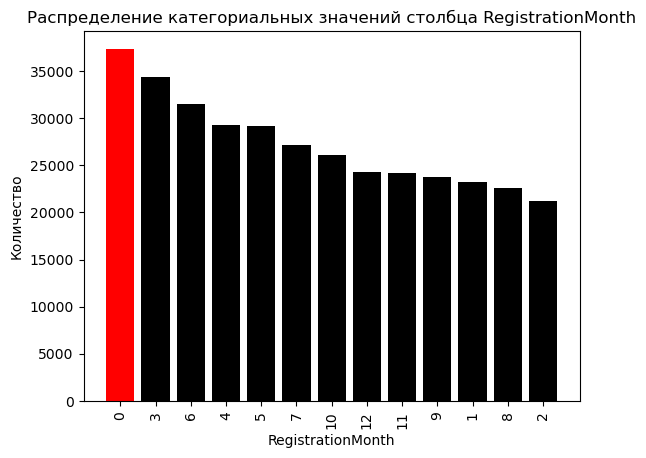

[ 0  5  8  6  7 10 12 11  2  3  1  4  9]


In [19]:
plot_column_diagram(data, 'RegistrationMonth')

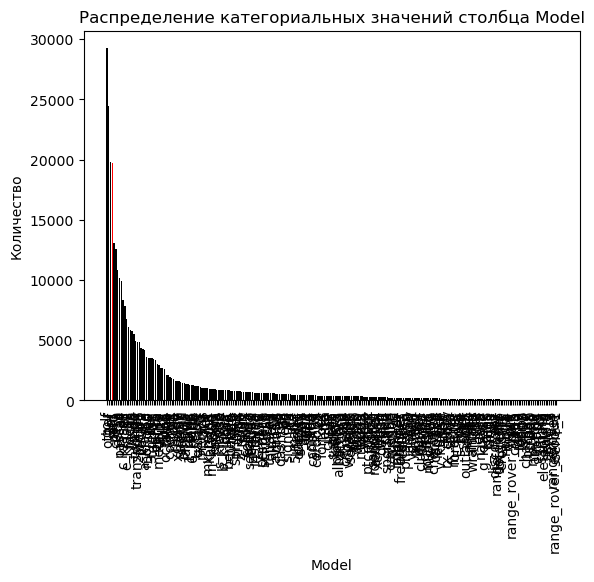

['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 'cuore' 's_max' 'a2' 'galaxy' 'c3' 'viano' 's_klasse'
 '1_reihe' 'avensis' 'roomster' 'sl' 'kaefer' 'santa' 'cooper' 'leon'
 '4

In [20]:
plot_column_diagram(data, 'Model')

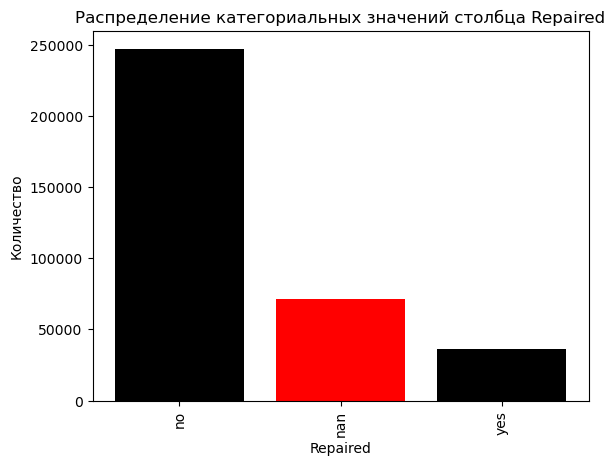

[nan 'yes' 'no']


In [21]:
plot_column_diagram(data, 'Repaired')

### Проведем предоработку и устранение ошибок

Для столбца <b>VehicleType</b> мы видим, что есть пустые значения, но также есть категория other, по сути можно пустоты заполнить значением other, но мне бы хотелось выбрать немного другой подход. я хочу сгруппировать датафрейм по модели и марке и взять самые распространенные значения для <b>VehicleType</b> оттуда, но пока что мы видим, что также в столбце <b>Model</b> есть пустые значения, поэтому этот метод мы ПОКА преминить не можем, поэтому начнем с заполнения пустот <b>Model</b>

Для столбца <b>RegistrationMonth</b>, судя по датафрейму сложно будет как-то ловко заполнить пустоты/0 корректными значениями, поэтому просто заменим 0 на медиану

In [22]:
median_month = data[data['RegistrationMonth'] != 0]['RegistrationMonth'].median()
data['RegistrationMonth'] = data['RegistrationMonth'].replace(0, median_month)

Мы видим, что в столбце <b>Brand</b> нет пустот, поэтому мы можем использовать этот столбец, чтобы заполнить пустые значения столбца <b>Model</b> самым часто встречающимся значением из столбца <b>Brand</b>

In [23]:
data['Model'] = data.groupby('Brand')['Model'].apply(lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x)

Проверим остались ли пустые значения в столбце <b>Model</b>

In [24]:
explore_data3 = check_df(data)

In [25]:
display(explore_data3)

,column,empty,duplicated,distinct
0,DateCrawled,0,0,271174
1,Price,0,0,3731
2,VehicleType,37490,0,8
3,RegistrationYear,0,0,151
4,Gearbox,19833,0,2
5,Power,0,0,712
6,Model,3374,0,250
7,Kilometer,0,0,13
8,RegistrationMonth,0,0,12
9,FuelType,32895,0,7


Осталось <b>3374</b> пустых значения в столбце <b>Model</b>, для них просто заполним пустоты значением <b>other</b>

In [26]:
data['Model'] = data['Model'].fillna('other')

Теперь у нас в столбцах <b>Model</b> и <b>Brand</b> нет пустых значений, поэтому теперь мы сможем заполнить пустоты столбца <b>VehicleType</b> путем группировки датафрейма по столбцам <b>Model</b> и <b>Brand</b> и заполнением самым распространенным значением пустот столбца <b>VehicleType</b>

In [27]:
data.loc[:, 'VehicleType'] = data.groupby(['Model', 'Brand'])['VehicleType'].apply(lambda x: x.fillna(x.mode().iat[0]))

Аналогичным образом поступим и в отношении столбцов <b>Gearbox</b> и <b>FuelType</b>

In [28]:
data['Gearbox'] = data.groupby(['Brand', 'Model'])['Gearbox'].apply(lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x)
data['Gearbox'] = data['Gearbox'].fillna('other')

data['FuelType'] = data.groupby(['Brand', 'Model'])['FuelType'].apply(lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x)
data['FuelType'] = data['FuelType'].fillna('other')

In [29]:
data['Type_of_fuel'] = 'other'

In [30]:
a_fuel = ['petrol', 'gasoline', 'lpg', 'cng']
b_fuel = ['hybrid', 'electric']

In [31]:
data.loc[data['FuelType'].isin(a_fuel), 'Type_of_fuel'] = 'usual'
data.loc[data['FuelType'].isin(b_fuel), 'Type_of_fuel'] = 'eco'

Для столбца <b>RegistrationYear</b> - там 150 уникальных значений, посмотрим что это такое

In [32]:
unique_values = data['RegistrationYear'].unique()
print(unique_values)

[1993 2011 2004 2001 2008 1995 1980 2014 1998 2005 1910 2016 2007 2009
 2002 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010
 2000 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1111 1969 1971
 1987 1986 1988 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977
 1961 1960 1966 1975 1963 1964 5000 1954 1958 1967 1959 9999 1956 3200
 1000 1941 8888 1500 2200 4100 1962 1929 1957 1940 3000 2066 1949 2019
 1937 1951 1800 1953 1234 8000 5300 9000 2900 6000 5900 5911 1933 1400
 1950 4000 1948 1952 1200 8500 1932 1255 3700 3800 4800 1942 7000 1935
 1936 6500 1923 2290 2500 1930 1001 9450 1944 1943 1934 1938 1688 2800
 1253 1928 1919 5555 5600 1600 2222 1039 9996 1300 8455 1931 1915 4500
 1920 1602 7800 9229 1947 1927 7100 8200 1946 7500 3500]


какая-то дичь

In [33]:
data['RegistrationYear'] = pd.to_numeric(data['RegistrationYear'], errors='coerce')

Создадим функцию, которая заменит непонятные значения на понятные, сначала найдем максимальное значение для столбца <b>DateCrawled</b> т.к. год регистрации машины не может быть позже даты скачивания анкеты

In [34]:
max_date_crawled = pd.to_datetime(data['DateCrawled'])
max_date_crawled.max()

Timestamp('2016-04-07 14:36:58')

Значит в функции верхняя граница будет 2016

In [35]:
def replace_year(group):
    median_year = int(group['RegistrationYear'].median())
    group['RegistrationYear'] = np.where(
        (group['RegistrationYear'] < 1950) | (group['RegistrationYear'] > 2016),
        median_year,
        group['RegistrationYear']
    )
    
    return group

Теперь используем созданную функцию, чтобы заменить нереальные значения на реальные

In [36]:
data = data.groupby(['VehicleType', 'Brand', 'Model']).apply(replace_year).reset_index(drop=True)

In [37]:
data = data.groupby(['Brand', 'Model']).apply(replace_year).reset_index(drop=True)

Для столбца <b>Repaired</b> посмотрим корреляцию значения "yes" в столбце ремонт от км

In [38]:
def plot_column_diagram(data, column, check, text):
    if check == 'nan':
        repaired_counts = data[data['Repaired'].isnull()][column].value_counts().sort_index()
    else:
        repaired_counts = data[data['Repaired'] == check][column].value_counts().sort_index()
    
    kilometer_labels = repaired_counts.index
    repaired_counts_values = repaired_counts.values
    
    fig, ax = plt.subplots()
    ax.bar(range(len(kilometer_labels)), repaired_counts_values, color='black')
    
    ax.set_xlabel('Kilometer')
    ax.set_ylabel('Количество')
    ax.set_title(f'Количество {text} для каждой категории км.')
    
    plt.xticks(range(len(kilometer_labels)), kilometer_labels, rotation=90)
    plt.show()

filtered_data = data.dropna(subset=['Repaired'])

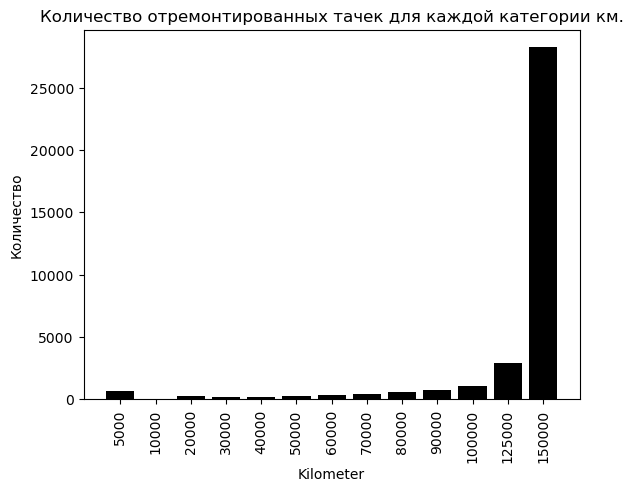

In [39]:
plot_column_diagram(filtered_data, 'Kilometer', 'yes', 'отремонтированных тачек')

Теперь посмотрим отдельно на км машин у которых нет значения в столбце <b>Repaired</b>

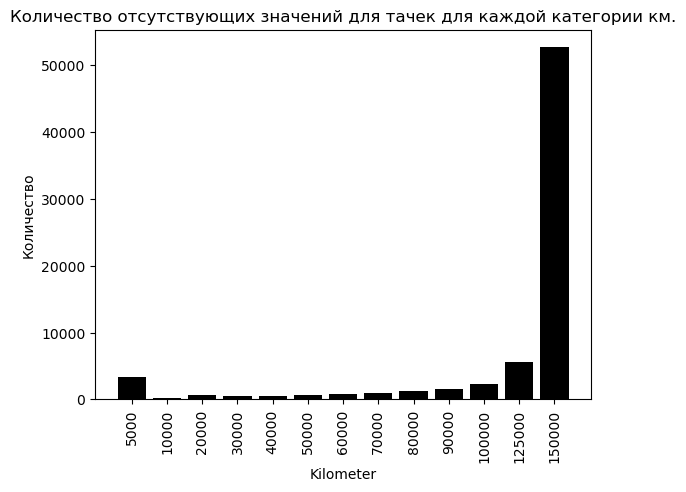

In [40]:
plot_column_diagram(data, 'Kilometer', 'nan', 'отсутствующих значений для тачек')

Заполним все пустоты столбца <b>Repaired</b> значением "yes"

In [41]:
data['Repaired'] = data['Repaired'].fillna('yes')

Теперь посмотрим на числовые признаки

In [42]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,2002.549261,110.093816,128211.363989,6.347083,0.0,50508.503800
std,4514.176349,6.719538,189.851330,37905.083858,3.170591,0.0,25783.100078
min,0.000000,1950.000000,0.000000,5000.000000,1.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,4.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2007.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,2016.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Странности
<br>
<b>Price</b> - Минимальное значение 0
<br>
<b>Power</b> - Минимальное значение 0, максмальноле значение 20000
<br>

Уберем строки с ценой меньше 99

In [43]:
data = data[data['Price'] > 99]

Уберем строки с мощностью л.с. меньше 10 и больше 350

In [44]:
data = data[(data['Power'] >= 10) & (data['Power'] <= 350)]

In [45]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,304642.000000,304642.000000,304642.000000,304642.000000,304642.000000,304642.0,304642.000000
mean,4810.095680,2002.855329,119.580783,128447.981565,6.356589,0.0,51156.540664
std,4565.651627,6.396341,51.573451,36655.418029,3.238608,0.0,25760.500378
min,100.000000,1950.000000,10.000000,5000.000000,1.000000,0.0,1067.000000
25%,1350.000000,1999.000000,75.000000,125000.000000,4.000000,0.0,30916.000000
50%,3100.000000,2003.000000,110.000000,150000.000000,6.000000,0.0,50170.000000
75%,6950.000000,2007.000000,150.000000,150000.000000,9.000000,0.0,71711.000000
max,20000.000000,2016.000000,350.000000,150000.000000,12.000000,0.0,99998.000000


In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304642 entries, 1 to 354364
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        304642 non-null  object
 1   Price              304642 non-null  int64 
 2   VehicleType        304642 non-null  object
 3   RegistrationYear   304642 non-null  int64 
 4   Gearbox            304642 non-null  object
 5   Power              304642 non-null  int64 
 6   Model              304642 non-null  object
 7   Kilometer          304642 non-null  int64 
 8   RegistrationMonth  304642 non-null  int64 
 9   FuelType           304642 non-null  object
 10  Brand              304642 non-null  object
 11  Repaired           304642 non-null  object
 12  DateCreated        304642 non-null  object
 13  NumberOfPictures   304642 non-null  int64 
 14  PostalCode         304642 non-null  int64 
 15  LastSeen           304642 non-null  object
 16  Type_of_fuel       3

In [47]:
unique_values = data['VehicleType'].unique()
print(unique_values)

['coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']


In [48]:
unique_values = data['FuelType'].unique()
print(unique_values)

['gasoline' 'petrol' 'lpg' 'other' 'hybrid' 'cng' 'electric']


После всех действий можно еще удалить <b>other</b>

In [49]:
data = data[(data['VehicleType'] != 'other') & (data['FuelType'] != 'other')]

### Подготовим данные для обучения

Создадим новый датафрейм, без лишних столбцов

In [50]:
columns=['Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired','PostalCode']

In [51]:
data_for_model = data[columns].copy()

In [52]:
data_for_model = data_for_model.reset_index(drop=True)

In [53]:
data_for_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302126 entries, 0 to 302125
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              302126 non-null  int64 
 1   VehicleType        302126 non-null  object
 2   RegistrationYear   302126 non-null  int64 
 3   Gearbox            302126 non-null  object
 4   Power              302126 non-null  int64 
 5   Model              302126 non-null  object
 6   Kilometer          302126 non-null  int64 
 7   RegistrationMonth  302126 non-null  int64 
 8   FuelType           302126 non-null  object
 9   Brand              302126 non-null  object
 10  Repaired           302126 non-null  object
 11  PostalCode         302126 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 27.7+ MB


In [54]:
missing_values_count = data_for_model.isnull().sum()
print(missing_values_count)

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
PostalCode           0
dtype: int64


Разделим данные на основную выборку и целевые признаки

In [55]:
features = data_for_model.drop(['Price'],axis=1)
target = data_for_model['Price']

Разделим тестовую и тренировочные выборки

In [56]:
train_features, test_features, train_target, test_target = train_test_split(features, target, test_size=0.25, random_state=RANDOM_SEED)

In [57]:
train_sample = train_features.shape[0]/features.shape[0]
test_sample = test_target.shape[0]/target.shape[0]

print('Размер тренировочной выборки: {:.0%}'.format(train_sample))
print('Размер тестовой выборки: {:.0%}'.format(test_sample))

Размер тренировочной выборки: 75%
Размер тестовой выборки: 25%


Категориальные признаки

In [58]:
col=['VehicleType', 'Gearbox','Model',
       'FuelType', 'Brand', 'Repaired']

In [59]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

encoder.fit(train_features[col])

encoded_train_features = train_features.copy()
encoded_train_features[col] = encoder.transform(train_features[col])

encoded_test_features = test_features.copy()
encoded_test_features[col] = encoder.transform(test_features[col])

## Обучение моделей

### LightGBM

In [79]:
param_grid_lgb = {
    'num_leaves': [10, 50, 100]
}

In [80]:
lgb_model = lgb.LGBMRegressor(random_state=RANDOM_SEED)

In [81]:
grid_search_lgb = GridSearchCV(lgb_model, param_grid_lgb)

In [82]:
start_time = time.time()
grid_search_lgb.fit(encoded_train_features, train_target)
training_time_lgb = time.time() - start_time

In [83]:
best_model_lgb = grid_search_lgb.best_estimator_
best_params_lgb = grid_search_lgb.best_params_
cv_results_lgb = grid_search_lgb.cv_results_

In [84]:
print("Лучшие параметры:", best_params_lgb)

Лучшие параметры: {'num_leaves': 100}


In [85]:
start_time = time.time()
predictions_lgb = best_model_lgb.predict(encoded_train_features)
prediction_time_lgb = time.time() - start_time

### Случайный лес

In [67]:
param_grid_rf = {
    'n_estimators': [100],
    'max_depth': [5]
}

In [68]:
rf_model = RandomForestRegressor(random_state=RANDOM_SEED)

In [69]:
grid_search_rf = GridSearchCV(rf_model, param_grid_rf)

In [70]:
start_time = time.time()
grid_search_rf.fit(encoded_train_features, train_target)
training_time_rf = time.time() - start_time

In [71]:
best_model_rf = grid_search_rf.best_estimator_
best_params_rf = grid_search_rf.best_params_
cv_results_rf = grid_search_rf.cv_results_

In [72]:
print("Лучшие параметры:", best_params_rf)

Лучшие параметры: {'max_depth': 5, 'n_estimators': 100}


In [73]:
start_time = time.time()
predictions_rf = best_model_rf.predict(encoded_train_features)
prediction_time_rf = time.time() - start_time

## Анализ моделей

### LightGBM

In [86]:
print("Модель LightGBM:")
print("Время обучения:", round(training_time_lgb, 2))
print("Скорость предсказания:", round(prediction_time_lgb, 2))

Модель LightGBM:
Время обучения: 7.24
Скорость предсказания: 0.16


### Случайный лес

In [75]:
print("Модель RandomForest:")
print("Время обучения:", round(training_time_rf, 2))
print("Скорость предсказания на тренировочной выборке:", round(prediction_time_rf, 2))

Модель RandomForest:
Время обучения: 84.01
Скорость предсказания на тренировочной выборке: 0.73


### Вывод

Сравнивая метрики, можно сделать следующие наблюдения:
<br>
<br>
Модель LightGBM имеет ниже значение RMSE (1547.24), что указывает на более точные предсказания, по сравнению с RMSE модели Случайного леса (2366.22).
<br>
<br>
Модель Случайного леса обучается немного дольше (84.01) по сравнению с моделью LightGBM (7.24), а также скорость предсказания у модели RandomForest (0.73) значительно медленнее, чем у модели LightGBM (0.16).

Используем LightGBM на тестовой выборке

In [76]:
predictions_test_lgb = best_model_lgb.predict(encoded_test_features)

In [77]:
rmse_lgb_test = mean_squared_error(test_target, predictions_test_lgb, squared=False)

In [78]:
print("RMSE на тестовой выборке:", round(rmse_lgb_test, 2))

RMSE на тестовой выборке: 1631.67


Исходя из требований RMSE на тестовой выборке не должен превышать 2500. 
<br>
Успех